In [1]:

import pandas as pd
import plotly.express as px
import datetime as dt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

warnings.filterwarnings('ignore')


In [2]:

def load_data():
    try:
        df = pd.read_csv('expense_data.csv')  # Assuming the CSV data
    except FileNotFoundError:
        print("CSV file not found, please load the file")
        return None
    return df


In [3]:

def date_str_validate():
    while True:
        date = input("Enter the date (YYYY-MM-DD) or 'today': ")
        if date == 'today':
            date = dt.date.today()
            break
        try: 
            date = dt.date.fromisoformat(date)
            break
        except:
            print("Incorrect data format, should be YYYY-MM-DD")
            continue
    return date


In [11]:

def cumulative_expenses(df):
    recent_data = pd.DataFrame(columns=['date', 'description', 'category', 'amount'])
    
    while True:
        date = date_str_validate()
        desc = input("What have you spent on? ")
        category = input("Enter the category of the expense: ")
        amount = float(input("How much did you spend? "))
        data = [[date, desc, category, amount]]
        new_df = pd.DataFrame(data, columns=['date', 'description', 'category', 'amount'])
        recent_data = pd.concat([recent_data, new_df], ignore_index=True)
        
        # Using pd.concat instead of append
        df = pd.concat([df, new_df], ignore_index=True)
        
        done = input('Type "done" when finished, or "else" to add more >> ')   
        if done == 'done':
            break
    df.to_csv('expense_data.csv', index=False)
    return df, recent_data



In [6]:

def logistic_regression_analysis(df):
    df['category_code'] = df['category'].astype('category').cat.codes
    df['exceed_threshold'] = (df['amount'] > 100).astype(int)

    X = df[['category_code']]
    y = df['exceed_threshold']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Model Accuracy: {accuracy}")
    print(f"Confusion Matrix:{cm}")

    return model, accuracy, cm


In [9]:
def analyze_expense(df):
    df['date'] = pd.to_datetime(df['date'])  # Convert date to datetime type
    df['year_month'] = df['date'].dt.to_period('M').astype(str)  # Extract year-month
    df['year'] = df['date'].dt.strftime('%Y')  # Extract year

    # Group by 'category' and calculate the mean only for the 'amount' column
    grouped_m = df.groupby(['category'])['amount'].mean().reset_index()  # Calculate mean of amount per category
    grouped_y_sum = df.groupby(['year', 'category'])['amount'].sum().reset_index()  # Total expenses per year-category

    # Sort values by amount
    grouped_m = grouped_m.sort_values('amount', ascending=False)
    grouped_y_sum = grouped_y_sum.sort_values(['year', 'amount'], ascending=True).reset_index(drop=True)

    # Extract category names for plotting
    cat_names = grouped_m['category'].values.tolist()
    
    # Monthly expenses pie chart
    fig = px.pie(grouped_m, values='amount', names='category', color='category', title="Average Monthly Expenses")
    fig.show()
    
    # Monthly total expenses bar chart
    fig = px.bar(df, x='year_month', y='amount', color='category', labels={'amount': 'Total Amount', 'year_month': 'Date'}, title='Monthly Total Expenses')
    fig.show()
    
    # Yearly total expenses bar chart
    fig = px.bar(grouped_y_sum, x='year', y='amount', color='category', labels={'amount': 'Amount', 'year': 'Year'}, title="Yearly Total Expenses by Category")
    fig.show()



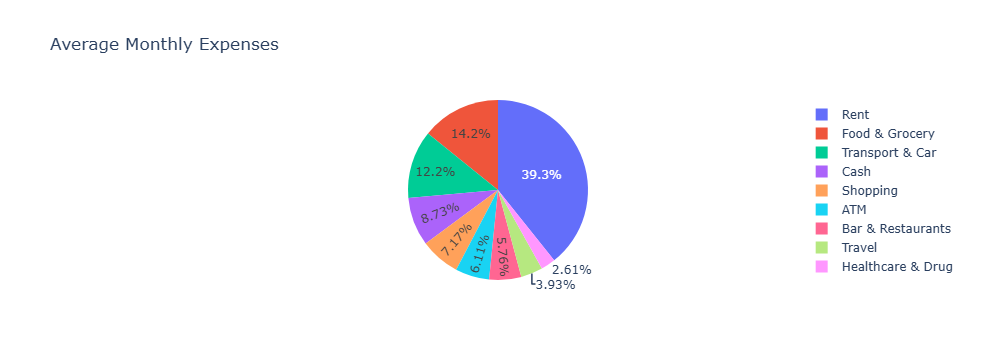

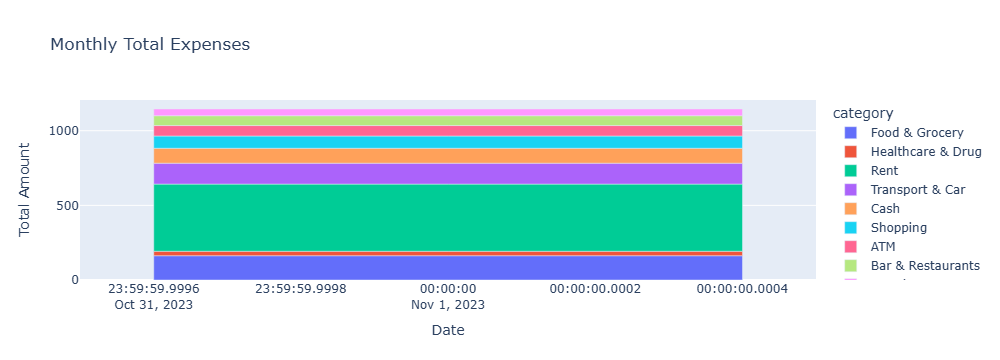

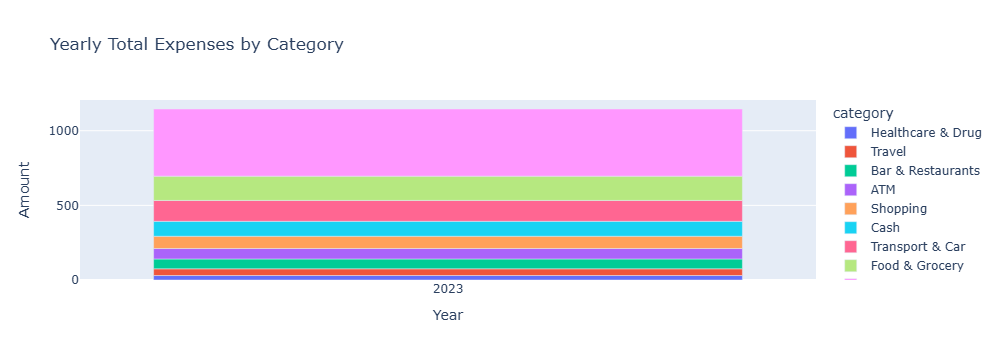

Model Accuracy: 1.0
Confusion Matrix:[[2]]


Enter the date (YYYY-MM-DD) or 'today':  today
What have you spent on?  cloth
Enter the category of the expense:  shopping
How much did you spend?  200
Type "done" when finished, or "else" to add more >>  done


In [12]:

if __name__ == '__main__':
    df = load_data()

    if df is not None:
        analyze_expense(df)

        model, accuracy, cm = logistic_regression_analysis(df)

        df, recent_data = cumulative_expenses(df)
